# TP1: análisis exploratorio

## Definiciones de funciones generales, imports, y carga de datos

In [5]:
# magic function para hacer que los graficos de matplotlib se renderizen en el notebook.

import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (18, 8)
%matplotlib inline

In [6]:
def show_and_save_plot(title,xlabel='', ylabel='', **kwargs):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig("./imgs/" + title + '.svg', **kwargs)
    plt.show()
    plt.close()

In [7]:
raw_eventos = pd.read_csv('data/events.csv')

/home/vasectomio/.virtualenvs/datos/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocesamiento

In [10]:
## To Do : Usar esto para agregar una nueva feature por marcas.
raw_eventos[pd.notnull(raw_eventos['model']) & ~(raw_eventos.model.str.lower().str.contains('iphone')|\
                                               raw_eventos.model.str.lower().str.contains('samsung') | \
                                               raw_eventos.model.str.lower().str.contains('lg') | \
                                               raw_eventos.model.str.lower().str.contains('motorola')| \
                                               raw_eventos.model.str.lower().str.contains('sony')| \
                                               raw_eventos.model.str.lower().str.contains('asus') | \
                                               raw_eventos.model.str.lower().str.contains('quantum') | \
                                               raw_eventos.model.str.lower().str.contains('ipad') | \
                                               raw_eventos.model.str.lower().str.contains('lenovo') | \
                                               raw_eventos.model.str.lower().str.contains('blackberry') \
                                                )]['model'].unique()

array([], dtype=object)

In [33]:
brands = {'iphone':'apple', 'samsung':'samsung', 'lg':'lg', 'motorola':'motorola', \
            'sony':'sony', 'asus':'asus', 'quantum':'quantum', 'ipad':'apple', 'lenovo':'lenovo', \
             'blackberry' : 'blackberry'}
def findBrand(x):
    if(pd.isna(x)):
        return np.nan
    for key,value in brands.items():
        if(key in x.lower()):
            return value
    return "Adsasdas"
    

In [34]:
raw_eventos['brand'] = raw_eventos['model'].map(findBrand)

# Funciones de limpieza de datos/creacion de features

In [12]:
raw_eventos.timestamp = raw_eventos.timestamp.map(pd.Timestamp)
raw_eventos.time = raw_eventos.timestamp.map(lambda it: it.hour)
def megapixel_count(resolution):
    if type(resolution) != str: return np.NaN
    x_pixels, y_pixels = map(int, resolution.split("x"))
    return x_pixels*y_pixels/1000000
raw_eventos.screen_megapixels = raw_eventos.screen_resolution.map(megapixel_count)

# Introduccion a los datos

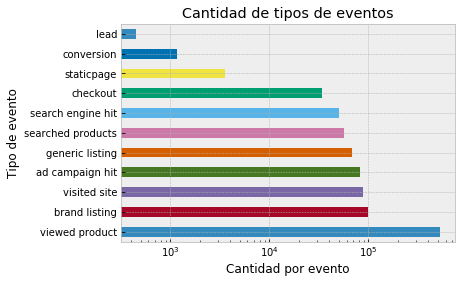

In [13]:
raw_eventos.event.value_counts().plot(kind='barh',logx=True)
show_and_save_plot('Cantidad de tipos de eventos','Cantidad por evento', 'Tipo de evento')

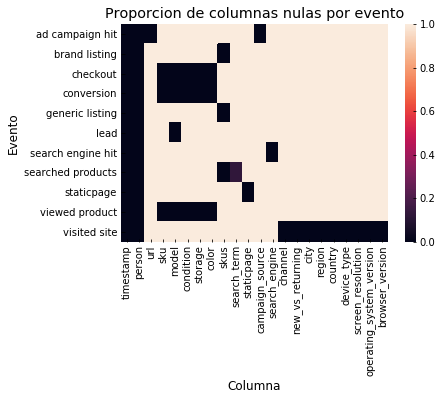

In [15]:
# Voy a intentar ver que proporcion de cada columna es nula
# Esto debería tener relación con que tipos de eventos tienen que atributos.
# Probablemente esta informacion salga de una db con un mapeo single_table
def myIsNa(serie):
    return serie.isna().sum() / len(serie.isna())
serie = pd.Series([1, 2, 3, np.NaN])
serie.isna().count()
grouped = raw_eventos.groupby('event').agg(myIsNa)
sns.heatmap(grouped)
# TODO: sacar la barra de color, confunde.
show_and_save_plot('Proporcion de columnas nulas por evento', pad_inches=0.3, bbox_inches='tight',
                   xlabel='Columna', ylabel='Evento')
del grouped

# Exploracion de los distintos tipos de eventos por separado

## Eventos de busqueda

In [16]:
# Podemos ver que la columna 'sku', se corresponde con los tipos de evento relacionados a un solo dispositivo
# Por otro lado, la columna 'skus', tiene un string que se corresponde con un listado de dispositivos.
busquedas = raw_eventos[raw_eventos.event == 'searched products'][['skus','timestamp','person','search_term']]
# verifico que para el mismo usuario y search_term hay resultados distintos, para validar lo anterior
busquedas[(busquedas.search_term.isna()) & (busquedas.person == '00aaa92e')]
del busquedas

## Eventos de visited_site

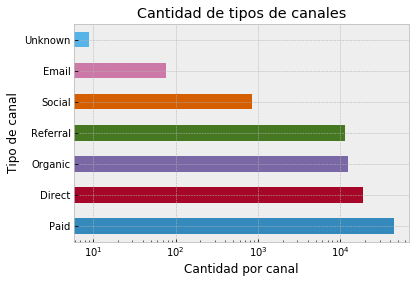

In [18]:
raw_eventos.channel.value_counts().plot(kind='barh',logx=True)
show_and_save_plot('Cantidad de tipos de canales', xlabel='Cantidad por canal',
                    ylabel='Tipo de canal')

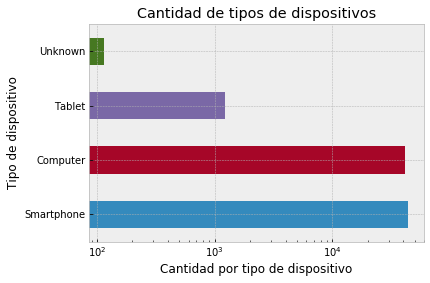

In [19]:
raw_eventos.device_type.value_counts().plot(kind='barh',logx=True)
show_and_save_plot('Cantidad de tipos de dispositivos', xlabel='Cantidad por tipo de dispositivo', ylabel='Tipo de dispositivo')

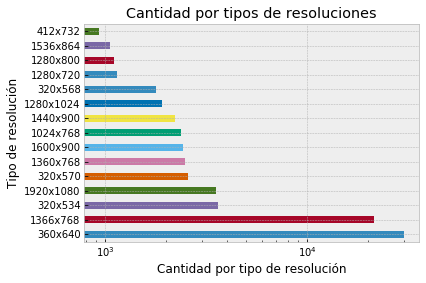

In [20]:
# Vemos que las resoluciones de pantalla son en general bajas, lo que da la idea
# de que la aplicación es usada por personas de bajo poder adquisitivo.
raw_eventos.screen_resolution.value_counts()[0:15].plot(kind='barh',logx=True)
show_and_save_plot('Cantidad por tipos de resoluciones', xlabel='Cantidad por tipo de resolución', 
                   ylabel='Tipo de resolución')

# Exploracion de todos los eventos en conjunto

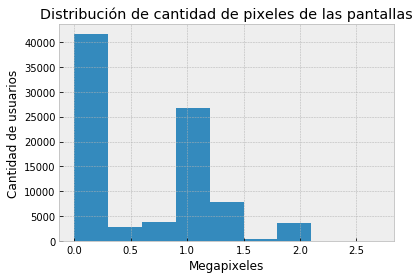

In [21]:
# Nos damos una idea de qué resoluciones de pantalla tienen los usuarios
raw_eventos.screen_megapixels.hist(bins=[x*0.3 for x in range(10)])
show_and_save_plot('Distribución de cantidad de pixeles de las pantallas', xlabel='Megapixeles',
                   ylabel='Cantidad de usuarios')

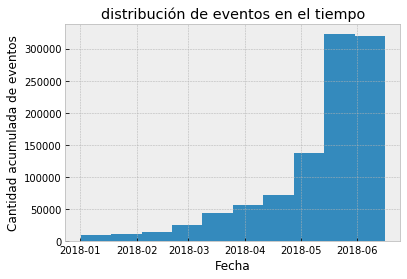

In [22]:
raw_eventos.timestamp.hist()
show_and_save_plot("distribución de eventos en el tiempo", xlabel='Fecha',
                   ylabel='Cantidad acumulada de eventos')

In [23]:
# Cuantos 'skus' distintos hay
print( "hay {} dispositivos y {} dispositivos distintos".format(len(raw_eventos.skus.dropna().values), len(raw_eventos.skus.unique())))

hay 221699 dispositivos y 35311 dispositivos distintos


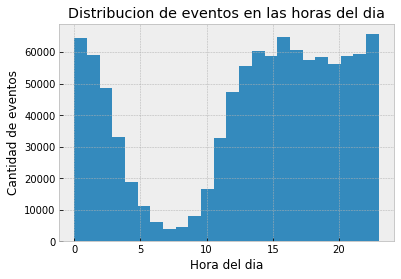

In [24]:
# Hora del dia en la que se producen los eventos:
raw_eventos.time.hist(bins=24)
show_and_save_plot('Distribucion de eventos en las horas del dia', xlabel='Hora del dia',
                   ylabel='Cantidad de eventos')

## Relación entre eventos de un mismo usuario
Primero voy a ver cuantos eventos hay por cada usuario ¿es usual que haya cientos por cada uno? ¿Solo un par?

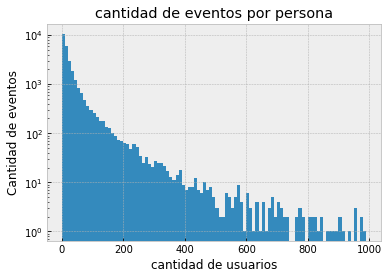

In [25]:
raw_eventos.person.value_counts().hist(log=True, bins=[i*10 for i in range(100)])
show_and_save_plot('cantidad de eventos por persona', xlabel='cantidad de usuarios',
                   ylabel='Cantidad de eventos')

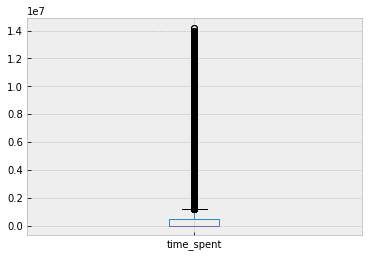

In [26]:
# TODO: plotear qué tanto tiempo pasan los usuarios en el sitio
persons = raw_eventos.groupby('person').agg({'timestamp':['min','max','count']})
persons['time_spent'] = persons['timestamp','max'] - persons['timestamp','min']
persons.time_spent = persons.time_spent.map(lambda it: it.total_seconds())
persons.time_spent.plot(kind='box')

## Features de cada modelo

In [27]:
def get_models_data(raw_events):
    def event_count_by_type(event_type, serie):
        return int(serie[serie == event_type].count())
    def viewed_product(it):
        return event_count_by_type('viewed product',it)
    def checkout(it):
        return event_count_by_type('checkout',it)
    def conversion(it):
        return event_count_by_type('conversion',it)
    def lead(it):
        return event_count_by_type('lead',it)
    event_functions = [ viewed_product, checkout, conversion, lead]
    models = raw_events\
        .groupby('model')\
        .agg({'timestamp':['count','min','max'],'event':event_functions})
    models['cantidad_eventos'] = models['timestamp','count']
    models = models.drop(labels=[('timestamp','count')],axis=1)
    models = models[models.cantidad_eventos > 100]
    for i in ['checkout', 'conversion','lead','viewed_product']:
        models['event',i] = models['event',i]/models['cantidad_eventos']
    return models

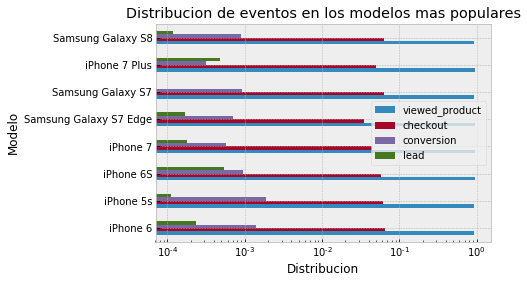

In [29]:
models = get_models_data(raw_eventos).sort_values('cantidad_eventos', ascending=False)
models.event.head(8).plot(kind='barh',logx=True, stacked=False)
show_and_save_plot('Distribucion de eventos en los modelos mas populares', xlabel='Distribucion', ylabel='Modelo')

Modelos de telefono mas vendidos en proporcion a los eventos totales

Vale la pena aclarar que son modelos distintos a los mas populares

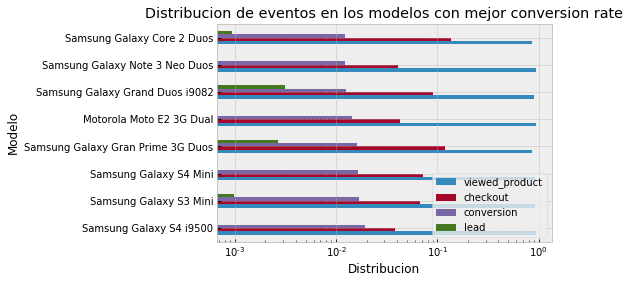

In [58]:
models = models.sort_values([('event','conversion')], ascending=False)
models.event.head(8).plot(kind='barh',logx=True, stacked=False)
plt.xlabel('Distribucion')
plt.ylabel('Modelo')
show_and_save_plot('Distribucion de eventos en los modelos con mejor conversion rate')

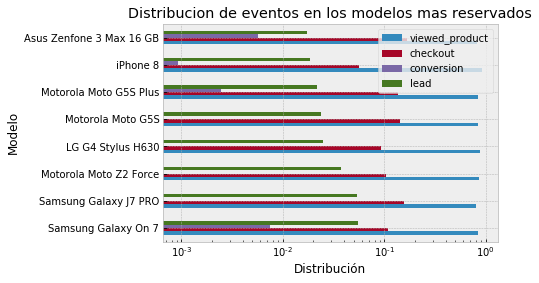

In [61]:
models = models.sort_values([('event','lead')], ascending=False)
models.event.head(8).plot(kind='barh',logx=True, stacked=False)
plt.xlabel('Distribución')
plt.ylabel('Modelo')
show_and_save_plot('Distribucion de eventos en los modelos mas reservados')

## Evaluo cuales son los colores mas vendidos.

In [22]:
colors_count = raw_eventos[raw_eventos.event == 'conversion'].color.dropna().value_counts()

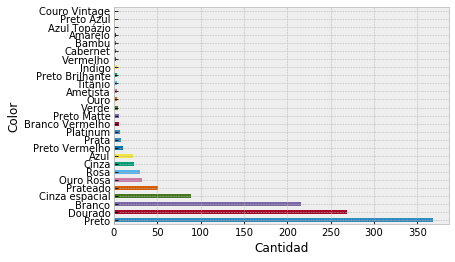

In [62]:
plt.xlabel('Cantidad')
plt.ylabel('Color')
colors_count.plot(kind = 'barh')